## Recruit Restaurant Visitor Forecasting

In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:

    Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
    AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

You must use the reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date. The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.
File Descriptions

This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

##### air_reserve.csv

This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

    air_store_id - the restaurant's id in the air system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

##### hpg_reserve.csv

This file contains reservations made in the hpg system.

    hpg_store_id - the restaurant's id in the hpg system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

##### air_store_info.csv

This file contains information about select air restaurants. Column names and contents are self-explanatory.

    air_store_id
    air_genre_name
    air_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

##### hpg_store_info.csv

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

    hpg_store_id
    hpg_genre_name
    hpg_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

##### store_id_relation.csv

This file allows you to join select restaurants that have both the air and hpg system.

    hpg_store_id
    air_store_id

##### air_visit_data.csv

This file contains historical visit data for the air restaurants.

    air_store_id
    visit_date - the date
    visitors - the number of visitors to the restaurant on the date

##### sample_submission.csv

This file shows a submission in the correct format, including the days for which you must forecast.

    id - the id is formed by concatenating the air_store_id and visit_date with an underscore
    visitors- the number of visitors forecasted for the store and date combination

##### date_info.csv

This file gives basic information about the calendar dates in the dataset.

    calendar_date
    day_of_week
    holiday_flg - is the day a holiday in Japan


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load info

In [2]:
air_info_df = pd.read_csv('./data/air_store_info.csv', index_col='air_store_id')
hpg_info_df = pd.read_csv('./data/hpg_store_info.csv',index_col='hpg_store_id')

store_info = air_info_df.merge(pd.read_csv('./data/store_id_relation.csv', index_col='air_store_id'), 
                               left_index=True, right_index=True, how='left')

store_info = store_info.merge(hpg_info_df, left_on='hpg_store_id', right_index=True, how='left')
print(store_info.shape)
store_info.head()

(829, 9)


,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
air_store_id,,,,,,,,,
air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


#### Load air reserve, visit and store info

In [3]:
air_reserve_df = pd.read_csv('./data/air_reserve.csv',
                             parse_dates = ['visit_datetime','reserve_datetime'])

air_reserve_group = air_reserve_df.groupby("air_store_id")

air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [4]:
air_visit_df = pd.read_csv('./data/air_visit_data.csv',
                          parse_dates=['visit_date'])

air_visit_group = air_visit_df.groupby("air_store_id")

air_visit_df.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


Количество уникальных ресторанов

In [5]:
len(air_visit_df.air_store_id.unique())

829

In [6]:
hpg_reserve_df = pd.read_csv('./data/hpg_reserve.csv', parse_dates=['visit_datetime','reserve_datetime'])
hpg_reserve_group = hpg_reserve_df.groupby("hpg_store_id")

In [8]:
air_stores = list(air_visit_group.groups.keys())

air_id is air_00a91d42b08b08d9, hpg_id is hpg_fbe603376b5980fc


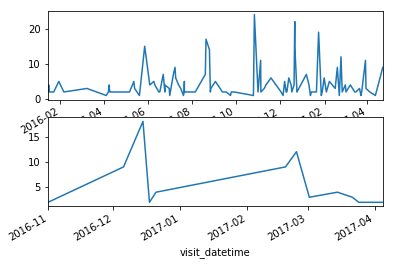

In [25]:
air_id = "air_00a91d42b08b08d9"

hpg_id = store_info.query('air_store_id == @air_id').hpg_store_id.values[0]

print("air_id is %s, hpg_id is %s"%(air_id, hpg_id))

visitors_an = air_visit_group.get_group(air_id).set_index('visit_date').drop('air_store_id', axis=1)

if air_id in list(air_reserve_group.groups.keys()):
    air_reserved = air_reserve_group.get_group(air_id)
    air_reserved_an = air_reserved['reserve_visitors'].groupby(air_reserved.visit_datetime.dt.floor('1h')).sum()

if hpg_id in list(hpg_reserve_group.groups.keys()):
    hpg_reserved = hpg_reserve_group.get_group(hpg_id)
    hpg_reserved_an = hpg_reserved['reserve_visitors'].groupby(hpg_reserved.visit_datetime.dt.floor('1h')).sum()
    
    
plt.subplot(211)    
hpg_reserved_an.plot()

plt.subplot(212)
air_reserved_an.plot()

#    plt.figure(figsize = [15, 5])
#    plt.subplot(211)
#    plt.plot(visitors_an.index, visitors_an.visitors)
#    plt.xlim(['2016-01','2017-05'])

#    plt.subplot(212)
#    plt.plot(reserved_an.index, reserved_an.values)
#    plt.xlim(['2016-01','2017-05'])
#else:
#    plt.figure(figsize = [15, 5])
#    plt.plot(visitors_an.index, visitors_an.visitors)
#    plt.xlim(['2016-01','2017-05'])

In [30]:
air_reserved_an.to_frame().merge(hpg_reserved_an.to_frame(),left_on=True)

TypeError: object of type 'NoneType' has no len()

In [56]:
c1 = hpg_reserved_an.to_frame()
c1.columns=['hpg']
c1.head()

,hpg
visit_datetime,
2016-01-14 19:00:00,2
2016-01-15 18:00:00,4
2016-01-16 18:00:00,2
2016-01-22 18:00:00,2
2016-01-29 18:00:00,5


In [57]:
c2 = air_reserved_an.to_frame()
c2.columns=['air']
c2.head()

,air
visit_datetime,
2016-10-31 20:00:00,2
2016-12-05 19:00:00,9
2016-12-14 19:00:00,18
2016-12-17 19:00:00,2
2016-12-20 20:00:00,4


In [62]:
booking = c1.merge(c2, how='outer', left_index=True, right_index=True).fillna(0)

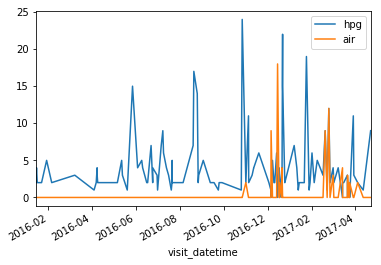

In [63]:
booking.plot()

In [315]:
store_info.query('air_store_id == @air_id').hpg_store_id.values

array([nan], dtype=object)

Что можно сделать?
- сгруппировать ряды и привести к единичному формату;
- обучить какие-то сходные модели;

Посмотреть на распределение заведений по категориям. Возможно, для некоторых из них достаточно не двух, а одного параметра для полного описания.

In [275]:
tb = pd.crosstab(store_info.hpg_genre_name,store_info.air_genre_name, dropna=False)
tb

air_genre_name,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
hpg_genre_name,,,,,,,,,,,,,,
Amusement bar,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Cafe,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Creation,0,0,0,0,1,0,0,4,0,0,0,0,0,0
Creative Japanese food,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Grilled meat,0,0,0,0,0,0,0,0,0,0,0,0,0,3
International cuisine,0,2,0,0,6,0,0,3,0,0,0,0,0,0
Italian,0,0,0,0,3,0,2,0,0,0,0,0,0,0
Japanese cuisine/Kaiseki,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Japanese food in general,0,0,0,0,0,0,0,0,1,0,0,0,0,0
